# Label Placement

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from IPython.display import clear_output

Загрузим несколько наборов точек, где каждой точке соответствует 2 варианта расположения подписи, и парсер файлов

In [ ]:
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/3_labelPlacement/bin1.txt
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/3_labelPlacement/bin2.txt
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/3_labelPlacement/bin3.txt
! wget https://github.com/glebelg/DataVisualization-2021/raw/main/3_labelPlacement/boxes_parse.py

clear_output()

In [ ]:
from boxes_parse import Box, Pos

Реализуем основные функции для расчета размещения подписей и их отрисовки на координатной плоскости

In [ ]:
def intersection(x1, y1, w1, h1, x2, y2, w2, h2):
    w1 += x1
    h1 += y1
    w2 += x2
    h2 += y2

    s1 = (x1 >= x2 and x1 <= w2) or (w1 >= x2 and w1 <= w2)
    s2 = (y1 >= y2 and y1 <= h2) or (h1 >= y2 and h1 <= h2)
    s3 = (x2 >= x1 and x2 <= w1) or (w2 >= x1 and w2 <= w1)
    s4 = (y2 >= y1 and y2 <= h1) or (h2 >= y1 and h2 <= h1)

    return ((s1 and s2) or (s3 and s4)) or ((s1 and s4) or (s3 and s2))


def get_conjunctions(boxes):
    conjunctions = []

    for i in range(1, len(boxes) + 1):
        box1 = boxes[i - 1]
        pos1_0 = box1.pos - box1.offsets[0]
        pos1_1 = box1.pos - box1.offsets[1]

        for j in range(i + 1, len(boxes) + 1):
            box2 = boxes[j - 1]
            pos2_0 = box2.pos - box2.offsets[0]
            pos2_1 = box2.pos - box2.offsets[1]

            truth_table = np.array([[intersection(*pos1_0, *box1.size.xy, *pos2_0, *box2.size.xy),
                                     intersection(*pos1_0, *box1.size.xy, *pos2_1, *box2.size.xy)],
                                    [intersection(*pos1_1, *box1.size.xy, *pos2_0, *box2.size.xy),
                                     intersection(*pos1_1, *box1.size.xy, *pos2_1, *box2.size.xy)]])

            if  truth_table[0][0]:
                conjunctions.append([-i, -j])
            if  truth_table[0][1]:
                conjunctions.append([-i, j])
            if  truth_table[1][0]:
                conjunctions.append([i, -j])
            if  truth_table[1][1]:
                conjunctions.append([i, j])

    return conjunctions

In [ ]:
class TwoSAT:
    def dfs1(self, v):
        self.used[v] = 1;
        for to in self.g[v]:
            if not self.used[to]:
                self.dfs1(to)
        self.order.append(v)


    def dfs2(self, v, c):
        self.tmp[v] = c
        for to in self.gr[v]:
            if self.tmp[to] == -1:
                self.dfs2(to, c)


    def build_implication_graph(self, n):
        self.g = [[] for _ in range(2 * n)]
        self.gr = [[] for _ in range(2 * n)]

        for a, b in self.conjunctions:
            a = 2 * a - 2 if a >= 0 else 2 * (-a) - 1
            b = 2 * b - 2 if b >= 0 else 2 * (-b) - 1
            
            self.g[a^1].append(b)
            self.g[b^1].append(a)
            self.gr[b].append(a^1)
            self.gr[a].append(b^1)


    def solve(self, boxes, conjunctions):
        self.boxes = boxes
        self.conjunctions = conjunctions
        self.order = []
        
        n = len(boxes)
        self.build_implication_graph(n)

        self.used = [0] * 2 * n
        for i in range(2 * n):
            if not self.used[i]:
                self.dfs1(i)

        c = 0
        self.tmp = [-1] * 2 * n
        for i in range(2 * n):
            v = self.order[2 * n - i - 1]
            if self.tmp[v] == -1:
                self.dfs2(v, c)
                c += 1

        placement = [0] * n
        for i in range(0, 2 * n, 2):
            if self.tmp[i] == self.tmp[i^1]:
                print('NO SOLUTION')
                return 
            placement[i // 2] = int(self.tmp[i] < self.tmp[i^1])

        return placement

In [ ]:
def get_boxes(file_path):
    raw_data = open(file_path).read()
    return [Box(line) for line in raw_data.strip().split('\n')]


def get_placement(boxes):
    conjunctions = get_conjunctions(boxes)
    placement = TwoSAT().solve(boxes, conjunctions)
    return placement

In [ ]:
def draw_all_labels(boxes):
    print('Все возможные варианты расположения подписей:')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    for box in boxes:
        rect1 = Rectangle(box.pos - box.offsets[0],
                        box.size.xy[0],
                        box.size.xy[1],
                        fill=False,
                        color ='green')

        rect2 = Rectangle(box.pos - box.offsets[1],
                        box.size.xy[0],
                        box.size.xy[1],
                        fill=False,
                        color ='blue')
        
        ax.add_patch(rect1)
        ax.add_patch(rect2)
    
    points = np.array([box.pos.xy for box in boxes])
    plt.plot(points[:,0], points[:,1], 'or')
    plt.show()


def draw_non_nonintersecting_labels(boxes, placement):
    if placement is None:
        print('Нельзя расположить подписи для каждой точки без пересечений!')
        return
    print('Расположение подписей для каждой точки без пересечений:')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    for i, box in enumerate(boxes):
        rect = Rectangle(box.pos - box.offsets[placement[i]],
                        box.size.xy[0],
                        box.size.xy[1],
                        fill=False,
                        color=['green', 'blue'][placement[i]])
        
        ax.add_patch(rect)

    points = np.array([box.pos.xy for box in boxes])
    plt.plot(points[:,0], points[:,1], 'or')
    plt.show()

Изобразим загруженные данные. Сначала посмотрим на все возможные варианты расположения подписей для каждой точки, далее оставим только непересекающиеся подписи, полученные с помощью алгоритма.

Все возможные варианты расположения подписей:


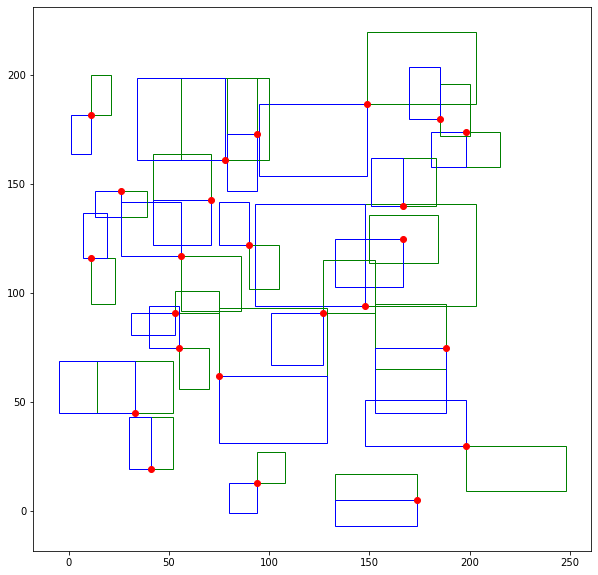

Расположение подписей для каждой точки без пересечений:


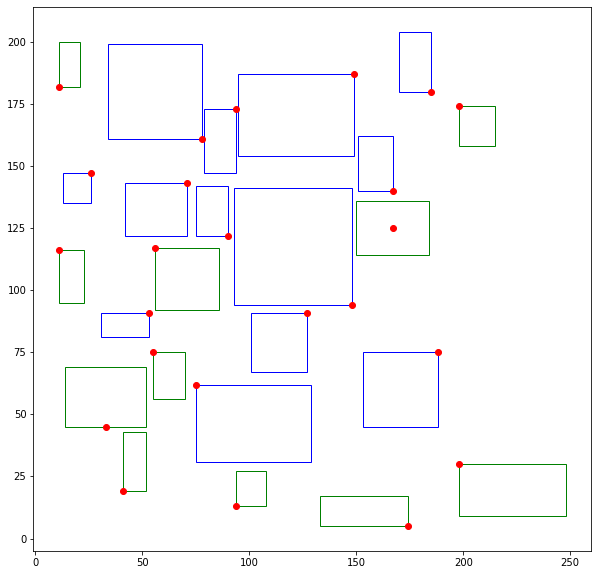

In [ ]:
boxes = get_boxes(file_path='bin1.txt')
placement = get_placement(boxes)

draw_all_labels(boxes)
draw_non_nonintersecting_labels(boxes, placement)

Все возможные варианты расположения подписей:


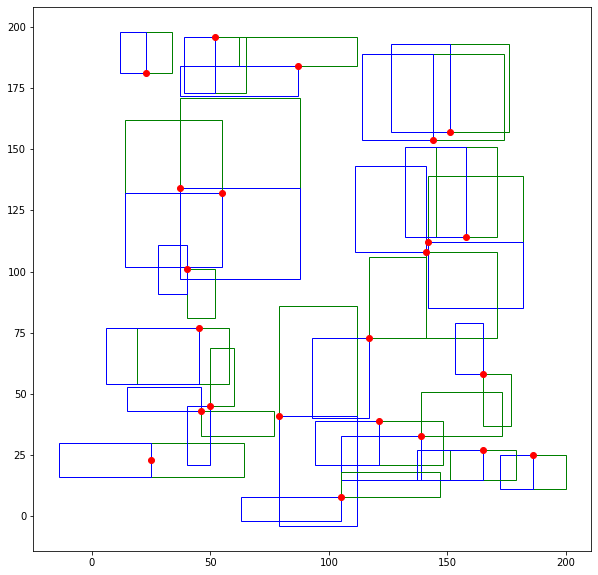

Расположение подписей для каждой точки без пересечений:


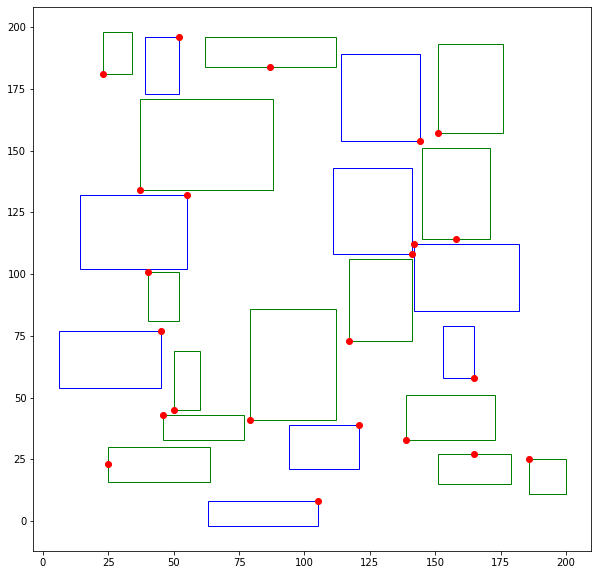

In [ ]:
boxes = get_boxes(file_path='bin2.txt')
placement = get_placement(boxes)

draw_all_labels(boxes)
draw_non_nonintersecting_labels(boxes, placement)

Все возможные варианты расположения подписей:


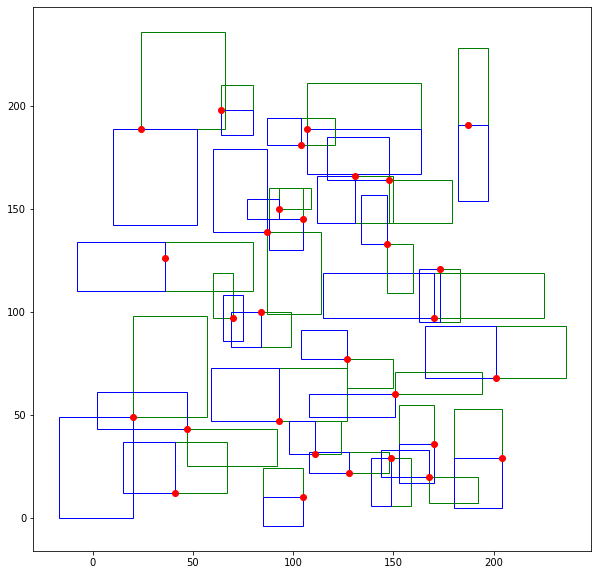

Расположение подписей для каждой точки без пересечений:


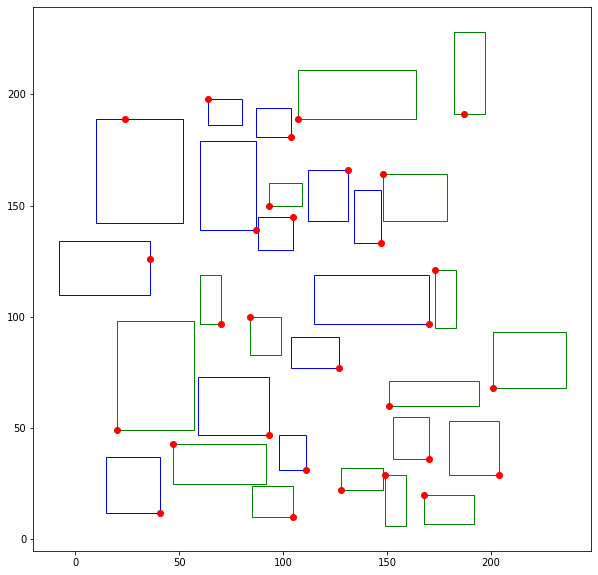

In [ ]:
boxes = get_boxes(file_path='bin3.txt')
placement = get_placement(boxes)

draw_all_labels(boxes)
draw_non_nonintersecting_labels(boxes, placement)